## 1. Importing Libraries

In [33]:
import pandas as pd 
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import joblib

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

from sklearn.pipeline import Pipeline

from sklearn.compose import ColumnTransformer

from feature_engine.datetime import DatetimeFeatures

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve





## 2. Display Settings


In [34]:
pd.set_option("display.max_columns", None)

In [35]:
sklearn.set_config(transform_output="default") #to avoid getting numpy outputs

## 3. Getting the Data

In [36]:
train_df = pd.read_csv("data/train.csv")
val_df = pd.read_csv("data/val.csv")
test_df = pd.read_csv("data/test.csv")

In [37]:
train_df

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187
...,...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info,4282
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info,13067
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info,4423
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info,7670


### 3.1 Split the Data

In [38]:
def split_data(data):
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [39]:
X_train, y_train = split_data(train_df)

In [40]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info
...,...,...,...,...,...,...,...,...,...
635,Air Asia,2019-04-12,Banglore,Delhi,04:55:00,07:45:00,170,0.0,No Info
636,Jet Airways,2019-05-09,Kolkata,Banglore,09:35:00,21:05:00,690,1.0,No Info
637,Indigo,2019-05-15,Banglore,Delhi,06:05:00,08:50:00,165,0.0,No Info
638,Multiple Carriers,2019-05-15,Delhi,Cochin,08:45:00,21:00:00,735,1.0,No Info


In [41]:
y_train

0       4995
1       8372
2       6117
3       7770
4       9187
       ...  
635     4282
636    13067
637     4423
638     7670
639    10844
Name: price, Length: 640, dtype: int64

In [42]:
X_val, y_val = split_data(val_df)

In [43]:
X_test, y_test = split_data(test_df)

print(X_test.shape, y_test.shape)

(200, 9) (200,)


### 3.2 Meta-info

In [44]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [45]:
num_cols = ["duration", "total_stops"]

dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [46]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [47]:
num_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="median")),
	("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("encoder", OneHotEncoder(sparse_output=False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
	("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
	("imputer", SimpleImputer(strategy="most_frequent")),
	("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
	("scaler", StandardScaler())
])

In [48]:
preprocessor = ColumnTransformer(transformers=[
	("num", num_transformer, num_cols),
	("cat", cat_transformer, cat_cols),
	("doj", doj_transformer, ["date_of_journey"]),
	("time", time_transformer, ["dep_time", "arrival_time"])
])

In [49]:
preprocessor.fit_transform(X_train)

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]], shape=(640, 33))

In [50]:
preprocessor.fit_transform(X_train).shape

(640, 33)

## 5. Model Selection

In [51]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "Support Vector Machine": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XGBoost": XGBRegressor(n_estimators=10)
    
}

In [52]:
data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [53]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
	ax.plot(
		sizes,
		mean_scores,
		marker="o",
		label=label
	)

	ax.fill_between(
		x=sizes,
		y1=mean_scores - std_scores,
		y2=mean_scores + std_scores,
		alpha=0.5
	)

In [54]:
def plot_learning_curves(name, algorithm, figsize=(12, 4)):
	model = Pipeline(steps=[
		("pre", preprocessor),
		("alg", algorithm)
	])

	train_sizes, train_scores, test_scores = learning_curve(
		estimator=model,
		X=X_data,
		y=y_data,
		cv=3,
		scoring="r2",
		n_jobs=-1,
		random_state=42
	)
	
	mean_train_scores = np.mean(train_scores, axis=1)
	std_train_scores = np.std(train_scores, axis=1)
	train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"

	mean_test_scores = np.mean(test_scores, axis=1)
	std_test_scores = np.std(test_scores, axis=1)
	test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

	fig, ax = plt.subplots(figsize=figsize)

	# training curve
	plot_curves(
		train_sizes,
		mean_train_scores,
		std_train_scores,
		f"Train ({train_score})",
		ax
	)

	# test curve
	plot_curves(
		train_sizes,
		mean_test_scores,
		std_test_scores,
		f"Test ({test_score})",
		ax
	)

	ax.set(xlabel="Training Set Size", ylabel="R-square", title=name)

	ax.legend(loc="lower right")

	plt.show()

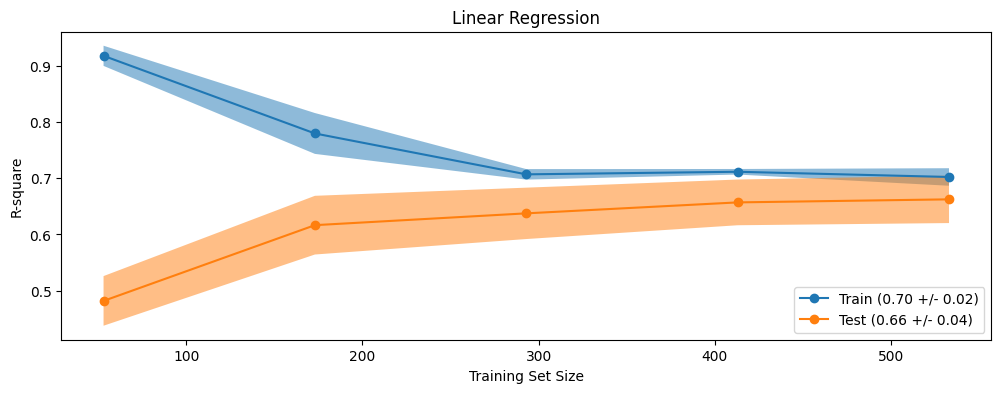

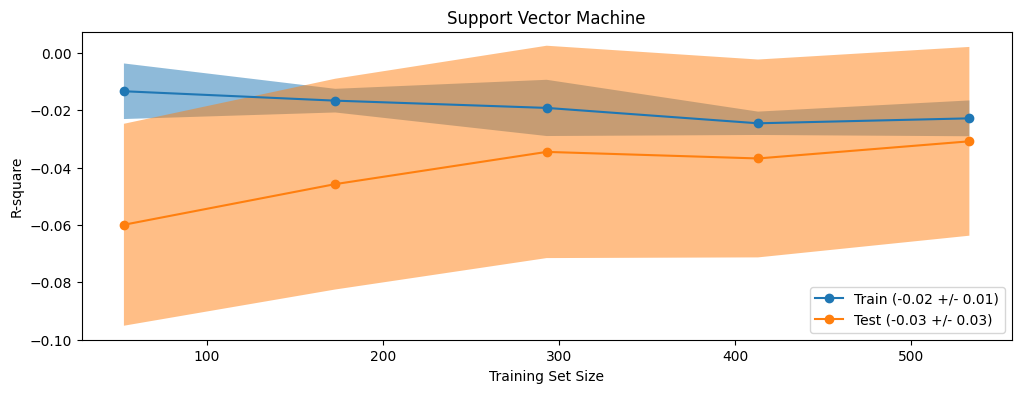

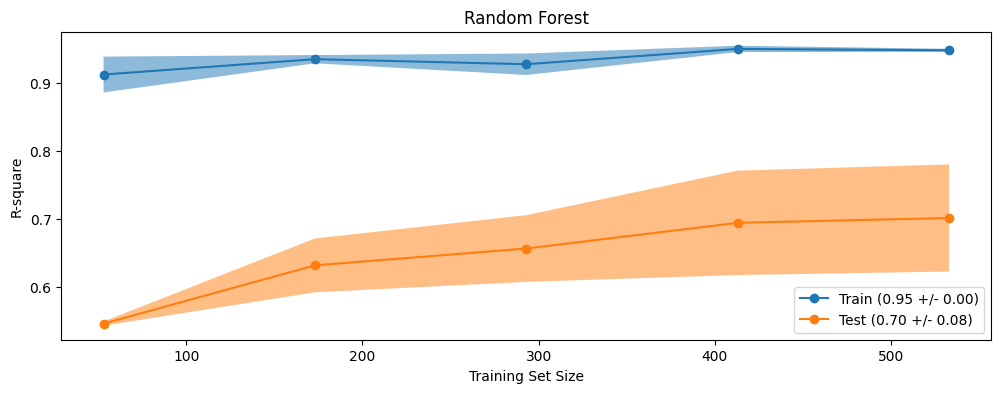

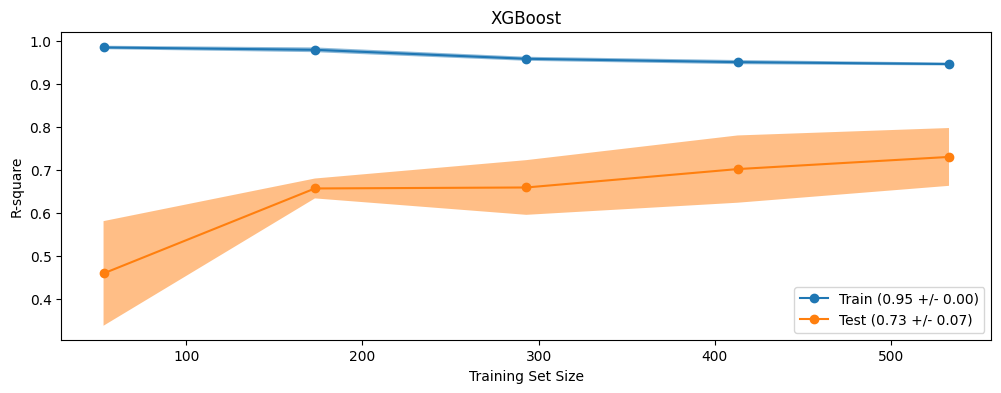

In [55]:
for name, alg in algorithms.items():
	plot_learning_curves(name, alg)

## 6. Model Training

In [56]:
model = Pipeline(steps=[
	("pre", preprocessor),
	("rf", RandomForestRegressor(n_estimators=10))
])

In [57]:
model.fit(X_data, y_data)


,steps,"[('pre', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 7. Model Evaluation

In [58]:
def evaluate_model(X, y):
	y_pred = model.predict(X)
	return r2_score(y, y_pred)

In [59]:
print(f"R2 score on Training data is = {evaluate_model(X_data, y_data)}")


R2 score on Training data is = 0.9635892954405534


In [60]:
print(f"R2 score on Test data is = {evaluate_model(X_test, y_test)}")


R2 score on Test data is = 0.6721016975527033


## 8. Model Persistence

In [61]:
joblib.dump(model, "model.joblib")


['model.joblib']

In [62]:
saved_model = joblib.load("model.joblib")
saved_model

,steps,"[('pre', ...), ('rf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [63]:
y_pred = saved_model.predict(X_test)

r2_score(y_test, y_pred)

0.6721016975527033